In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
np.random.seed(1) #set seed to reproduce results

# 1)

In [3]:
two_moons = np.genfromtxt('http://www0.cs.ucl.ac.uk/staff/M.Herbster/SL/misc/twomoons.dat', delimiter = '') 

In [4]:
#separate data into X and class labels y
X = two_moons[:,1:]
y = two_moons[:,0]

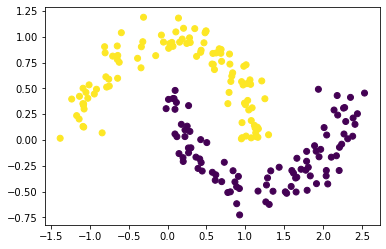

In [5]:
#visualise data coloured by class labels
plt.scatter(X[:,0], X[:,1], c = y)

In [6]:

def create_W(X, c):
    #takes in data X and outputs adjacency matrix W
    l = X.shape[0]
    #initialise l x l adjacency matrix
    W = np.zeros(shape = (l, l))
    
    #calculate similarity measures by row 
    if X.ndim == 3:
        for i in range(l):
            W[i, :] = np.exp(((-c)*(np.linalg.norm(X - X[i,:,:], axis = (1,2)))**2))
    else:
        for i in range(l):
            W[i, :] = np.exp(((-c)*(np.linalg.norm(X - X[i,:], axis = 1))**2))
    return W


In [7]:

def create_L(W):
    #takes adjacency matrix W as input and outputs graph laplacian matrix
    l = W.shape[0]
    D = np.zeros((l,l))
    for i in range(l):
        D[i,i] = np.sum(W[i,:])
    return D - W

In [8]:
def spec_cluster(X, y, c):
    #performs spectral clustering on dataset X with ground truth class labels y and parameter c
    #outpuots cluster labels y_hat and measure of cluster correctness 
    W = create_W(X, c)
    L = create_L(W)
    #generate eigensystem for L
    vals, vecs = np.linalg.eig(L)
    
    #find eigenvector corresponding to second smallest eigenvalue
    vec2 = vecs[:,vals.argsort()[1]]
    #assign cluster labels based on sign of eigenvector
    pred = lambda x: -1 if x < 0 else 1
    y_hat = list(map(pred, vec2))
    correct = (np.array(y == y_hat).sum()/len(y))
    incorrect = (np.array(y != y_hat).sum()/len(y))
    return np.array(y_hat), max(correct, incorrect)

In [9]:
def find_best_c(X, y, c_low = -10, c_high = 10):
    #performs spectral clustering with a range of values of c, outputs the c which gets the highest measure of cluster correctness
    best = (0,0)
    for i in np.arange(-10.0, 10.0, step = 0.1):
        y_hat, er =  spec_cluster(X, y , 2**i)
        if er > best[1]:
            best = (i, er)
    return best

In [10]:
find_best_c(X, y)

(4.299999999999949, 1.0)

In [11]:
y_hat, error = spec_cluster(X, y , 2**find_best_c(X, y)[0])

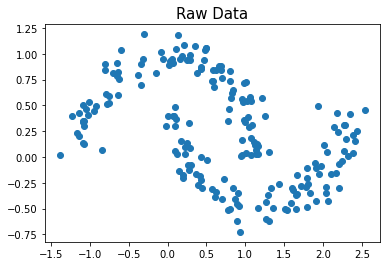

In [12]:
#plot raw data
fig, ax = plt.subplots()

plt.scatter(X[:,0], X[:,1])
ax.set_title('Raw Data', fontsize = 15);

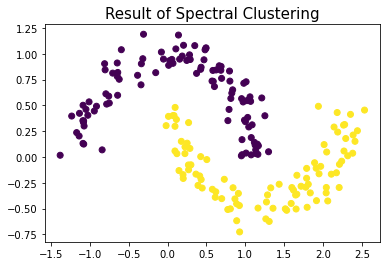

In [13]:
#plot result of spectral clustering for best value of c
fig, ax = plt.subplots()
ax.scatter(X[:,0], X[:,1], c  = y_hat)
ax.set_title('Result of Spectral Clustering', fontsize = 15);

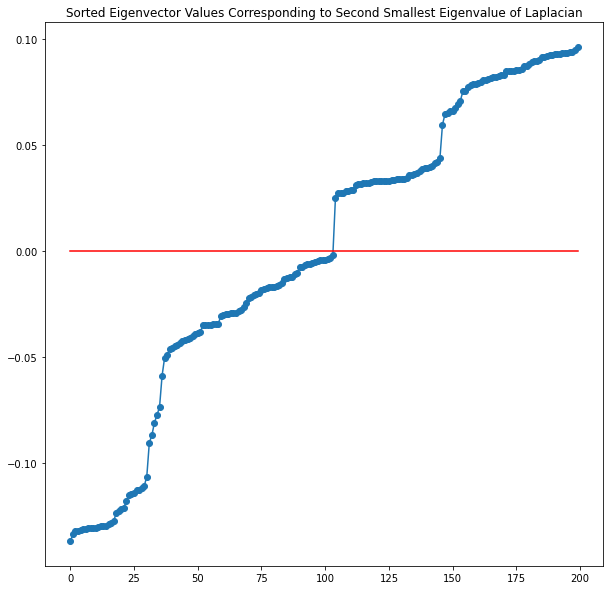

In [14]:
#visualise second eigenvector
L = create_L(create_W(X, c = 2**4.3))
vals, vecs = np.linalg.eig(L)
#get eigenvector corresponding to second smallest eigenvalue
vec2 = vecs[:,vals.argsort()[1]]

fig, ax = plt.subplots(figsize = (10, 10))
plt.scatter(np.arange(200), np.sort(vec2))
plt.plot(np.arange(200), np.sort(vec2))
plt.plot(np.arange(200), np.zeros(200), c= 'red')
ax.set_title('Sorted Eigenvector Values Corresponding to Second Smallest Eigenvalue of Laplacian')
ax.tick_params(which = 'both', axis = 'both', labelsize = 10)

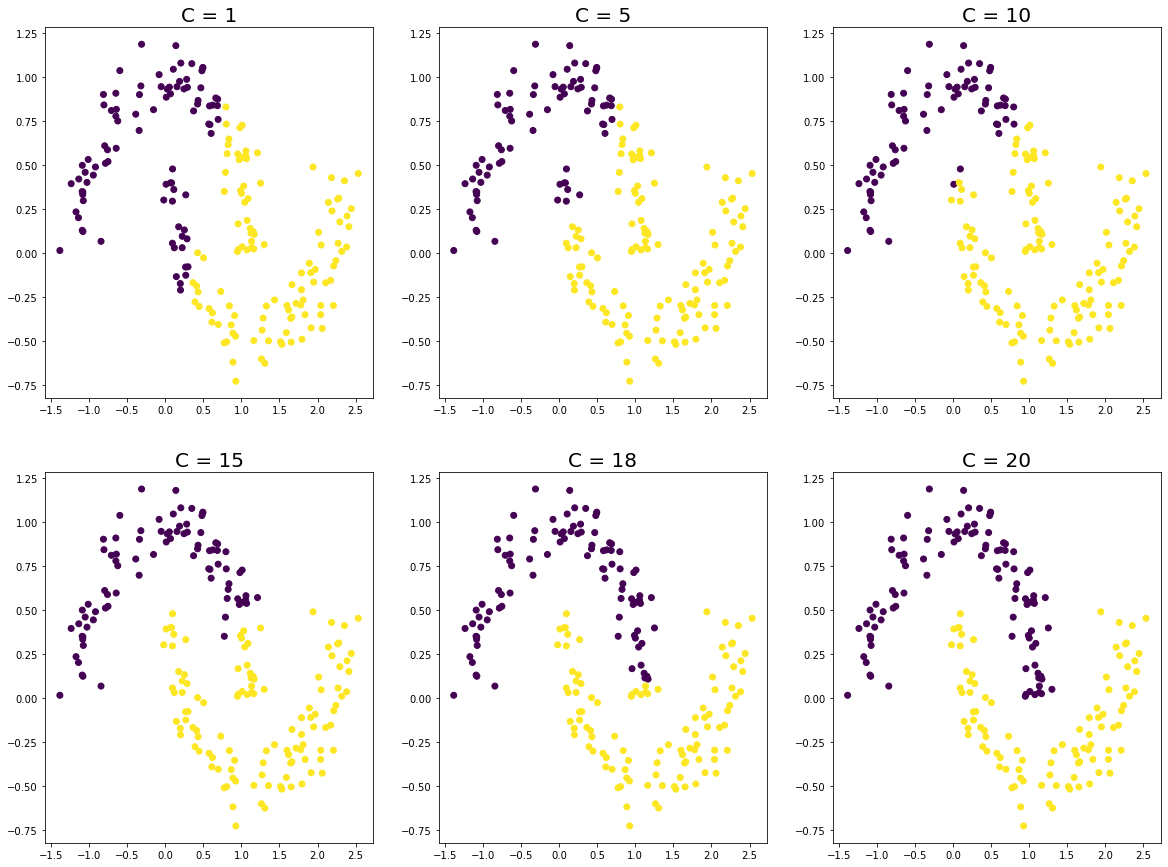

In [15]:
#visualise effect of c
cs = [ 1, 5, 10, 15, 18, 20]
fig, ax = plt.subplots(2,len(cs)//2, figsize = (20, 15))
for i in range(len(cs)):
    y_hat, error = spec_cluster(X, y , cs[i])
    if y_hat[0] == 1:
        y_hat *= -1
    if i <= 2:
        ax[0,i  ].scatter(X[:,0], X[:,1], c  = y_hat)
        ax[0,i ].set_title(f'C = {cs[i]}', fontsize = 20)
    else:
        ax[1,i-3 ].scatter(X[:,0], X[:,1], c  = y_hat)
        ax[1,i -3 ].set_title(f'C = {cs[i]}', fontsize = 20)
    

# 2)

In [16]:
def sample_data(n, mu, sigma):
    #returns a sample from 2-dimensional isotropic Gaussian
    data = np.random.normal(loc = mu, scale = sigma, size = n*2).reshape(n, 2)
    return data

In [17]:
#sample the data
class_neg_one = sample_data(20, -0.3, 0.2)
class_one = sample_data(20, 0.15, 0.1)
X = np.append(class_neg_one, class_one, axis = 0)

In [18]:
#create vector of class labels
y = np.append(-np.ones(20),np.ones(20))

In [19]:
#
find_best_c(X, y)

(6.899999999999942, 1.0)

In [20]:
y_hat, error = spec_cluster(X, y , 2**find_best_c(X, y)[0])

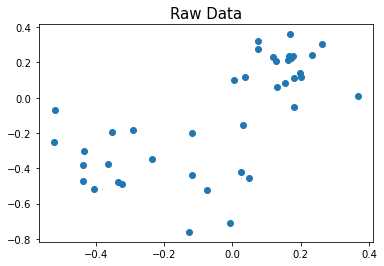

In [21]:
#plot raw data
fig, ax = plt.subplots()

plt.scatter(X[:,0], X[:,1])
ax.set_title('Raw Data', fontsize = 15);

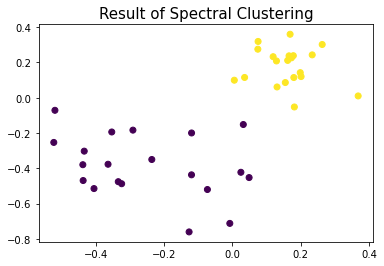

In [22]:
#plot result of spectral cluster 
fig, ax = plt.subplots()

plt.scatter(X[:,0], X[:,1], c = y_hat)
ax.set_title('Result of Spectral Clustering', fontsize = 15);

# 3)

In [23]:
digits = np.genfromtxt('http://www0.cs.ucl.ac.uk/staff/M.Herbster/SL/misc/dtrain123.dat', delimiter = '')

In [24]:
#format data
y = digits[:,0]
X = digits[:, 1:].reshape(329, 16, 16)

In [25]:
#choose only the digits where y = 1 or 3
X = X[np.where((y == 1) | (y == 3))]
y = y[np.where((y == 1) | (y == 3))]

In [26]:
y[np.where(y == 3)] = -1
y[np.where(y == 1)] = 1

In [27]:
correctness = []
#carry out spectral clustering on digit dataset for range of c values
for c in np.arange(.001, .1, 0.001):
    correctness.append(spec_cluster(X, y, c)[1])
    

In [28]:
#find best c value
np.arange(.001, .1, 0.001)[np.array(correctness).argmin()]

0.063

Text(0, 0.5, 'correctness')

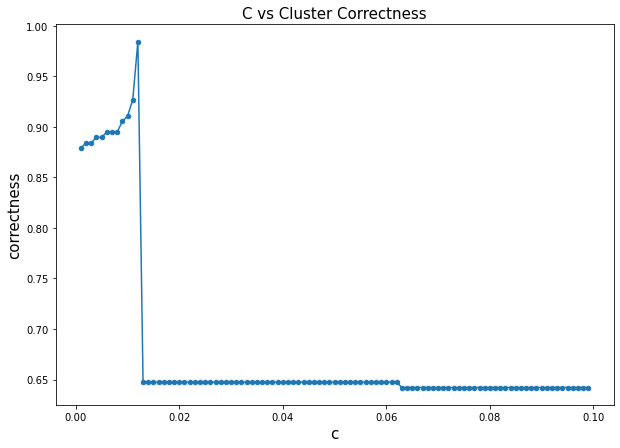

In [29]:
#visualise c values 
fig, ax = plt.subplots(figsize = (10,7))
plt.plot(np.arange(0.001, .1, 0.001), correctness)
plt.scatter(np.arange(0.001, .1, 0.001), correctness, s = 20)
ax.tick_params(axis = 'both', which = 'both', labelsize = 10)
ax.set_title('C vs Cluster Correctness',fontsize = 15)
ax.set_xlabel('c', fontsize = 15)
ax.set_ylabel('correctness',  fontsize = 15)